In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/MyDrive/Dataset/cancer-semantic-segmentation-data.zip

Mounted at /content/drive
Archive:  drive/MyDrive/Dataset/cancer-semantic-segmentation-data.zip
   creating: Data/
   creating: Data/images_test/
  inflating: Data/images_test/ytma55_030603_benign5_ccd.tif  
  inflating: Data/images_test/ytma55_030603_benign6_ccd.tif  
   creating: Data/images_train/
  inflating: Data/images_train/ytma10_010704_benign1_ccd.tif  
  inflating: Data/images_train/ytma10_010704_benign2_ccd.tif  
  inflating: Data/images_train/ytma10_010704_benign3_ccd.tif  
  inflating: Data/images_train/ytma10_010704_malignant1_ccd.tif  
  inflating: Data/images_train/ytma10_010704_malignant2_ccd.tif  
  inflating: Data/images_train/ytma10_010704_malignant3_ccd.tif  
  inflating: Data/images_train/ytma12_010804_benign1_ccd.tif  
  inflating: Data/images_train/ytma12_010804_benign2_ccd.tif  
  inflating: Data/images_train/ytma12_010804_benign3_ccd.tif  
  inflating: Data/images_train/ytma12_010804_malignant1_ccd.tif  
  inflating: Data/images_train/ytma12_010804_malignant2_

In [2]:
from tensorflow.keras import backend, callbacks, metrics, layers, models
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import os

In [3]:
DATASET_URL = r"https://drive.google.com/file/d/1xT5rTdjoK9jNvnz8QqcfO1re1pF7YKPD"

TRAIN_IMAGE_PATH = os.path.join("Data", "images_train")
TRAIN_MASK_PATH = os.path.join("Data", "masks_train")
TEST_IMAGE_PATH = os.path.join("Data", "images_test")
TEST_MASK_PATH = os.path.join("Data", "masks_test")

DEF_HEIGHT, DEF_WIDTH = 768, 896
DES_HEIGHT, DES_WIDTH = 256, 256

DEF_SHAPE = (DEF_HEIGHT, DEF_WIDTH)
DES_SHAPE = (DES_HEIGHT, DES_WIDTH)

DEF_SHAPE_RGB = (*DEF_SHAPE, 3)
DES_SHAPE_RGB = (*DES_SHAPE, 3)

VALIDATION_SIZE = .1
BATCH_SIZE = 5
EPOCHS = 100

SCALE = True  # scale data from 0 to 1
FOCUS_PATCH = True  # crop to keep only patch parts of image
CHECKPOINT_PATH = "checkpoint.keras"
RESIZE_OPTIONS = {
    'mode': 'constant',
    'anti_aliasing': True,
    'preserve_range': True
}

In [4]:
def mean_IOU_evaluator(y_true, y_pred):
    precisions = []

    for t in np.arange(.5, 1, .05):
        y_pred = tf.cast(y_pred>t, tf.int32)
        score, up_opt = tf.metrics.MeanIoU(y_true, y_pred, 2)
        backend.get_session().run(tf.local_variables_initializer())
        with tf.control_depencies([up_opt]):
            score = tf.identify(score)

        precisions.append(score)

    return backend.mean(backend.stack(precisions), axis=0)

In [5]:
def load_data():
    train_files = os.listdir(TRAIN_IMAGE_PATH)
    train_shape = (len(train_files), *DEF_SHAPE)
    train_images = np.empty((*train_shape, 3))
    train_masks = np.empty(train_shape)

    for idx, train_file in enumerate(train_files):
        filename, ext = os.path.splitext(train_file)
        image_path = os.path.join(TRAIN_IMAGE_PATH, train_file)
        mask_path = os.path.join(TRAIN_MASK_PATH, filename.rstrip('_ccd')+ext.upper())

        train_images[idx] = imread(image_path)
        train_masks[idx] = imread(mask_path)


    test_files = os.listdir(TEST_IMAGE_PATH)
    test_shape = (len(test_files), *DEF_SHAPE)
    test_images = np.empty((*test_shape, 3))
    test_masks = np.empty(test_shape)

    for i, test_file in enumerate(test_files):
        filename, ext = os.path.splitext(test_file)
        image_path = os.path.join(TEST_IMAGE_PATH, test_file)
        mask_path = os.path.join(TEST_MASK_PATH, filename.rstrip('_ccd')+ext.upper())

        test_images[i] = imread(image_path)
        test_masks[i] = imread(mask_path)


    return train_images, train_masks, test_images, test_masks

In [6]:
def preprocess(images, masks):
    new_images = np.empty((len(images), *DES_SHAPE_RGB))
    new_masks = np.empty((len(masks), *DES_SHAPE))

    for i in range(len(images)):
        image = images[i]
        mask = masks[i]

        if FOCUS_PATCH:
            y_coord, x_coord = np.where(mask == 255)
            y_slice = slice(y_coord.min(), y_coord.max())
            x_slice = slice(x_coord.min(), x_coord.max())
            image = image[y_slice, x_slice]
            mask = mask[y_slice, x_slice]

        if SCALE:
            image = image / 255
            mask = mask /255

        new_images[i] = resize(image, DES_SHAPE_RGB, **RESIZE_OPTIONS)
        new_masks[i] = resize(mask, DES_SHAPE, **RESIZE_OPTIONS)

    return new_images, new_masks

In [7]:
train_images, train_masks, test_images, test_masks = load_data()

In [8]:
train_X, train_M = preprocess(train_images, train_masks)
test_X, test_M = preprocess(test_images, test_masks)

## U-Net Architecture

In [9]:
conv_options = {
    'activation': 'elu',
    'padding': 'same',
    'kernel_initializer': 'he_normal'
}

### Input

In [10]:
inputs = layers.Input(DES_SHAPE_RGB)
# inputs = layers.Lambda(lambda x: x/255)(inputs)  # we did normalize before

### Convoluting

#### First-Layer

In [11]:
c1 = layers.Conv2D(32, 3, **conv_options)(inputs)
c1 = layers.Dropout(.1)(c1)
c1 = layers.Conv2D(32, 3, **conv_options)(c1)

p1 = layers.MaxPooling2D(2)(c1)

#### Second-Layer

In [12]:
c2 = layers.Conv2D(64, 3, **conv_options)(p1)
c2 = layers.Dropout(.1)(c2)
c2 = layers.Conv2D(64, 3, **conv_options)(c2)

p2 = layers.MaxPooling2D(2)(c2)

#### Third-Layer

In [13]:
c3 = layers.Conv2D(128, 3, **conv_options)(p2)
c3 = layers.Dropout(.15)(c3)
c3 = layers.Conv2D(128, 3, **conv_options)(c3)

p3 = layers.MaxPooling2D(2)(c3)

#### 4th-Layer

In [14]:
c4 = layers.Conv2D(256, 3, **conv_options)(p3)
c4 = layers.Dropout(.2)(c4)
c4 = layers.Conv2D(256, 3, **conv_options)(c4)

p4 = layers.MaxPooling2D(2)(c4)

#### 5th-Layer

In [15]:
c5 = layers.Conv2D(512, 3, **conv_options)(p4)
c5 = layers.Dropout(.25)(c5)
c5 = layers.Conv2D(512, 3, **conv_options)(c5)

### Upsampling

#### 6th-Layer

In [16]:
u6 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
u6 = layers.concatenate([u6, c4])

c6 = layers.Conv2D(256, 3, **conv_options)(u6)
c6 = layers.Dropout(.2)(c6)
c6 = layers.Conv2D(256, 3, **conv_options)(c6)

#### 7th-Layer

In [17]:
u7 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
u7 = layers.concatenate([u7, c3])

c7 = layers.Conv2D(128, 3, **conv_options)(u7)
c7 = layers.Dropout(.15)(c7)
c7 = layers.Conv2D(128, 3, **conv_options)(c7)

#### 8th-Layer

In [18]:
u8 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
u8 = layers.concatenate([u8, c2])

c8 = layers.Conv2D(64, 3, **conv_options)(u8)
c8 = layers.Dropout(.1)(c8)
c8 = layers.Conv2D(32, 3, **conv_options)(c8)

#### 9th-Layer

In [19]:
u9 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
u9 = layers.concatenate([u9, c1])

c9 = layers.Conv2D(32, 3, **conv_options)(u9)
c9 = layers.Dropout(.1)(c9)
c9 = layers.Conv2D(32, 3, **conv_options)(c9)

#### Output

In [20]:
outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

### Assembling

In [21]:
model = models.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['dropout[0][0]']             
                                                                                              

### Callbacks

In [22]:
class MaskPredicter(callbacks.Callback):
    def __init__ (self, idx=0, step=10, record=False):
        self.idx = idx
        self.step = step
        self.mask = train_M[self.idx]
        self.image = train_X[self.idx]
        self.image_ = np.expand_dims(self.image, axis=0)  # image for using in model.predict
        self.record = record  # if record the history of predicted masks
        self.history = []

    def predict(self):
        return np.squeeze(self.model.predict(self.image_)[0])

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.step != 0:
            return

        predicted_mask = self.predict()
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        fig.suptitle(f'{epoch+1}th Epoch (idx={self.idx})')
        ax1.set_title(f'Actual Mask')
        ax1.imshow(self.mask)
        ax2.set_title(f'Predicted Mask')
        ax2.imshow(predicted_mask)
        fig.tight_layout()
        plt.show()

        if self.record:
            self.history.append(predicted_mask)

In [23]:
# earlystopper = callbacks.EarlyStopping(patience=10)
checkpointer = callbacks.ModelCheckpoint(CHECKPOINT_PATH, save_best_only=True, verbose=1)
maskpredicter = MaskPredicter(10)

### Training

Epoch 1/100
 6/10 [=================>............] - ETA: 0s - loss: 288.0085 - mse: 0.1718

10/10 [==============================] - ETA: 0s - loss: 274.2966 - mse: 0.1453
Epoch 1: val_loss improved from inf to 299.71075, saving model to checkpoint.h5


1/1 [==============================] - 0s 484ms/step


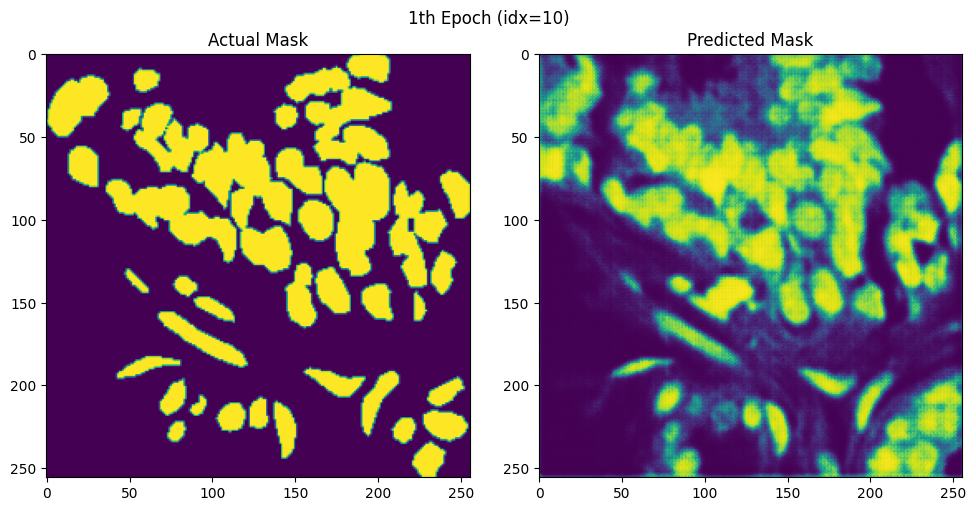

10/10 [==============================] - 32s 702ms/step - loss: 274.2966 - mse: 0.1453 - val_loss: 299.7108 - val_mse: 0.0862
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 259.5483 - mse: 0.0791
Epoch 2: val_loss did not improve from 299.71075
10/10 [==============================] - 2s 149ms/step - loss: 259.5483 - mse: 0.0791 - val_loss: 303.5572 - val_mse: 0.1111
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 257.2750 - mse: 0.0765
Epoch 3: val_loss improved from 299.71075 to 295.26016, saving model to checkpoint.h5
10/10 [==============================] - 2s 186ms/step - loss: 257.2750 - mse: 0.0765 - val_loss: 295.2602 - val_mse: 0.0860
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 256.2192 - mse: 0.0720
Epoch 4: val_loss did not improve from 295.26016
10/10 [==============================] - 1s 140ms/step - loss: 256.2192 - mse: 0.0720 - val_loss: 296.0606 - val_mse: 0.0955
Epoch 5/100
10/10 [====================

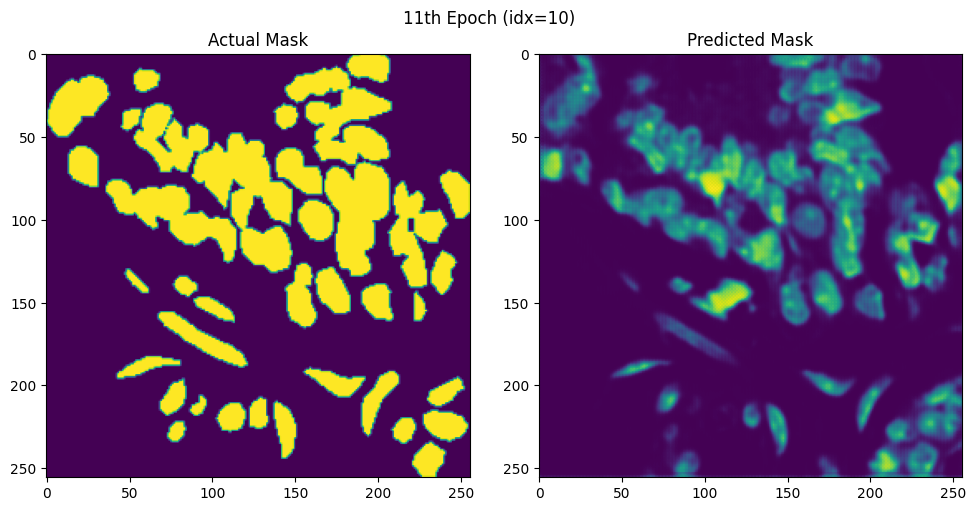

10/10 [==============================] - 2s 230ms/step - loss: 255.6207 - mse: 0.0739 - val_loss: 298.9889 - val_mse: 0.1145
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 254.8116 - mse: 0.0726
Epoch 12: val_loss did not improve from 295.26016
10/10 [==============================] - 1s 140ms/step - loss: 254.8116 - mse: 0.0726 - val_loss: 304.1301 - val_mse: 0.1282
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 255.9532 - mse: 0.0773
Epoch 13: val_loss did not improve from 295.26016
10/10 [==============================] - 1s 141ms/step - loss: 255.9532 - mse: 0.0773 - val_loss: 301.4598 - val_mse: 0.1387
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 255.7046 - mse: 0.0814
Epoch 14: val_loss did not improve from 295.26016
10/10 [==============================] - 1s 141ms/step - loss: 255.7046 - mse: 0.0814 - val_loss: 299.3767 - val_mse: 0.1234
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 2

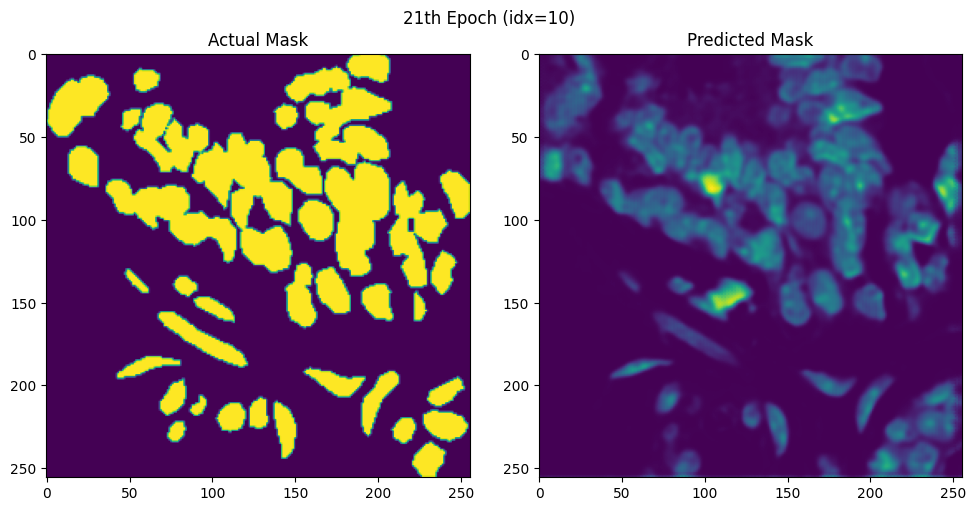

10/10 [==============================] - 2s 202ms/step - loss: 254.5440 - mse: 0.0801 - val_loss: 294.4348 - val_mse: 0.1367
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 253.6191 - mse: 0.0816
Epoch 22: val_loss did not improve from 293.73163
10/10 [==============================] - 1s 140ms/step - loss: 253.6191 - mse: 0.0816 - val_loss: 299.0794 - val_mse: 0.1223
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 253.7341 - mse: 0.0749
Epoch 23: val_loss improved from 293.73163 to 293.44675, saving model to checkpoint.h5
10/10 [==============================] - 2s 175ms/step - loss: 253.7341 - mse: 0.0749 - val_loss: 293.4467 - val_mse: 0.1289
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 253.3850 - mse: 0.0917
Epoch 24: val_loss did not improve from 293.44675
10/10 [==============================] - 1s 140ms/step - loss: 253.3850 - mse: 0.0917 - val_loss: 294.9274 - val_mse: 0.1376
Epoch 25/100
10/10 [==============

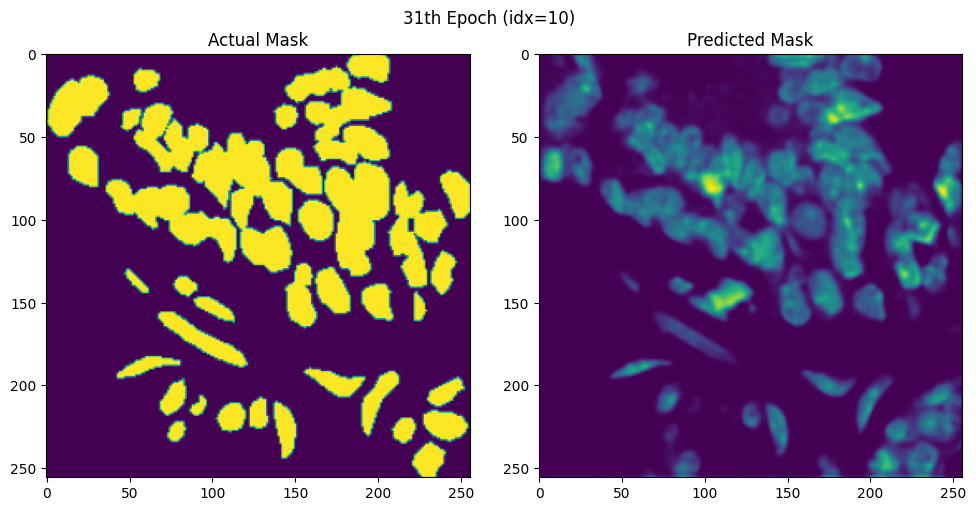

10/10 [==============================] - 2s 202ms/step - loss: 253.3273 - mse: 0.0833 - val_loss: 295.3109 - val_mse: 0.1411
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 253.7760 - mse: 0.0882
Epoch 32: val_loss did not improve from 293.44675
10/10 [==============================] - 1s 141ms/step - loss: 253.7760 - mse: 0.0882 - val_loss: 300.6213 - val_mse: 0.1386
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 253.1635 - mse: 0.0785
Epoch 33: val_loss improved from 293.44675 to 293.10681, saving model to checkpoint.h5
10/10 [==============================] - 2s 177ms/step - loss: 253.1635 - mse: 0.0785 - val_loss: 293.1068 - val_mse: 0.1304
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 252.6396 - mse: 0.0919
Epoch 34: val_loss did not improve from 293.10681
10/10 [==============================] - 1s 144ms/step - loss: 252.6396 - mse: 0.0919 - val_loss: 293.3047 - val_mse: 0.1426
Epoch 35/100
10/10 [==============

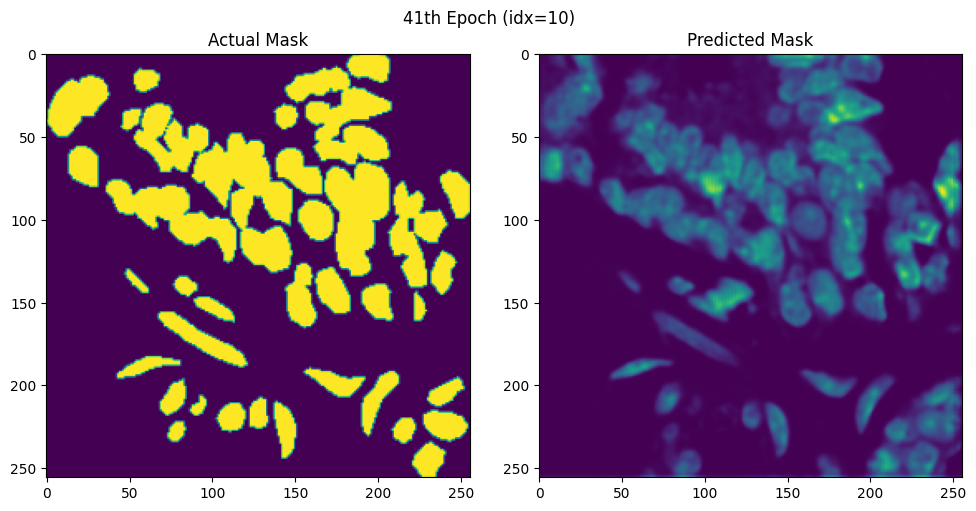

10/10 [==============================] - 2s 206ms/step - loss: 252.8789 - mse: 0.1122 - val_loss: 293.3770 - val_mse: 0.1555
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 252.9972 - mse: 0.0925
Epoch 42: val_loss did not improve from 293.10681
10/10 [==============================] - 1s 142ms/step - loss: 252.9972 - mse: 0.0925 - val_loss: 293.2370 - val_mse: 0.1412
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 252.8937 - mse: 0.1029
Epoch 43: val_loss did not improve from 293.10681
10/10 [==============================] - 1s 143ms/step - loss: 252.8937 - mse: 0.1029 - val_loss: 293.6245 - val_mse: 0.1637
Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 252.3330 - mse: 0.1006
Epoch 44: val_loss did not improve from 293.10681
10/10 [==============================] - 1s 147ms/step - loss: 252.3330 - mse: 0.1006 - val_loss: 293.9992 - val_mse: 0.1394
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 2

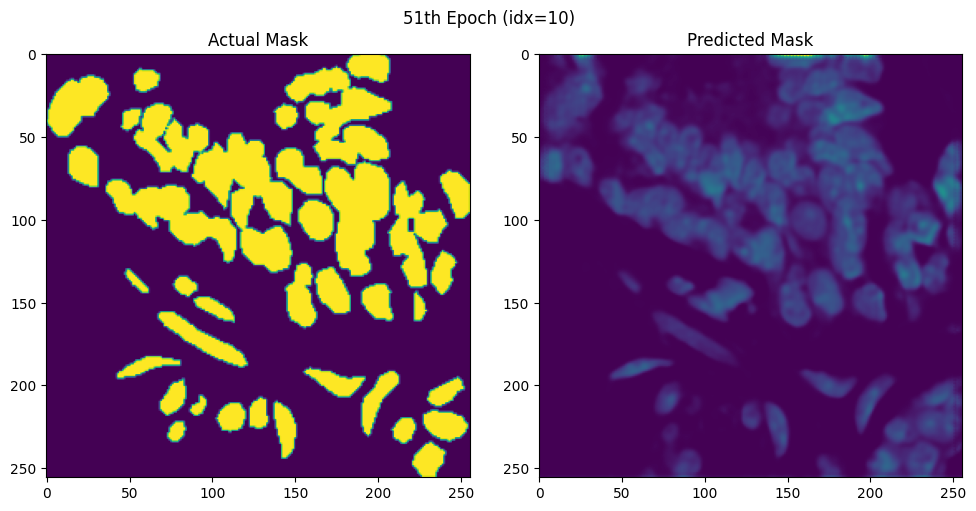

10/10 [==============================] - 2s 209ms/step - loss: 252.2216 - mse: 0.1067 - val_loss: 292.6763 - val_mse: 0.1595
Epoch 52/100
10/10 [==============================] - ETA: 0s - loss: 253.2477 - mse: 0.1017
Epoch 52: val_loss did not improve from 292.22031
10/10 [==============================] - 1s 144ms/step - loss: 253.2477 - mse: 0.1017 - val_loss: 294.0033 - val_mse: 0.1441
Epoch 53/100
10/10 [==============================] - ETA: 0s - loss: 252.1780 - mse: 0.0922
Epoch 53: val_loss did not improve from 292.22031
10/10 [==============================] - 1s 144ms/step - loss: 252.1780 - mse: 0.0922 - val_loss: 293.0992 - val_mse: 0.1602
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 251.7766 - mse: 0.1101
Epoch 54: val_loss did not improve from 292.22031
10/10 [==============================] - 1s 148ms/step - loss: 251.7766 - mse: 0.1101 - val_loss: 293.4905 - val_mse: 0.1603
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 2

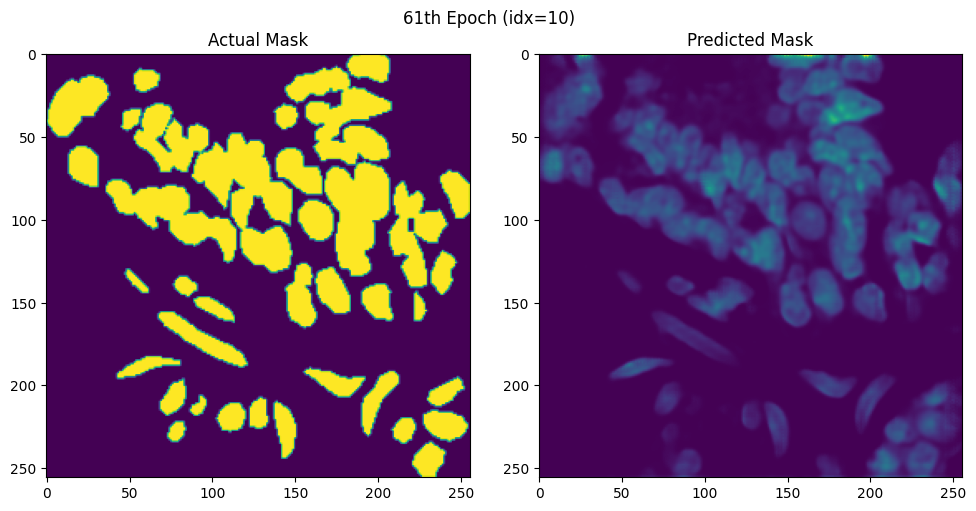

10/10 [==============================] - 2s 238ms/step - loss: 251.6884 - mse: 0.1036 - val_loss: 291.9431 - val_mse: 0.1613
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 251.2895 - mse: 0.1000
Epoch 62: val_loss did not improve from 291.94308
10/10 [==============================] - 1s 145ms/step - loss: 251.2895 - mse: 0.1000 - val_loss: 292.3820 - val_mse: 0.1479
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 251.3603 - mse: 0.1088
Epoch 63: val_loss did not improve from 291.94308
10/10 [==============================] - 1s 145ms/step - loss: 251.3603 - mse: 0.1088 - val_loss: 294.5587 - val_mse: 0.1685
Epoch 64/100
10/10 [==============================] - ETA: 0s - loss: 251.1376 - mse: 0.1039
Epoch 64: val_loss did not improve from 291.94308
10/10 [==============================] - 1s 149ms/step - loss: 251.1376 - mse: 0.1039 - val_loss: 292.4145 - val_mse: 0.1514
Epoch 65/100
10/10 [==============================] - ETA: 0s - loss: 2

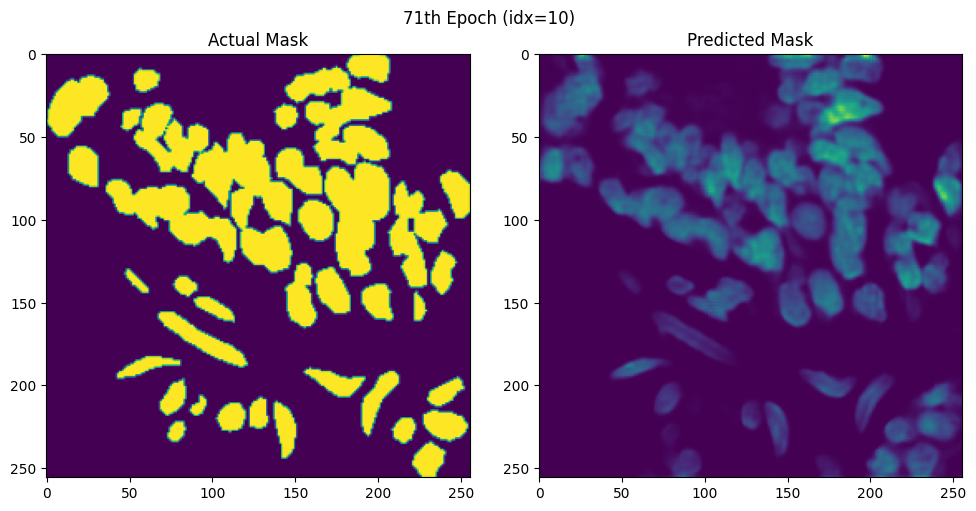

10/10 [==============================] - 2s 209ms/step - loss: 250.5745 - mse: 0.1028 - val_loss: 293.6189 - val_mse: 0.1571
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 251.1622 - mse: 0.0956
Epoch 72: val_loss did not improve from 291.50058
10/10 [==============================] - 1s 146ms/step - loss: 251.1622 - mse: 0.0956 - val_loss: 293.0420 - val_mse: 0.1551
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 250.5610 - mse: 0.1029
Epoch 73: val_loss did not improve from 291.50058
10/10 [==============================] - 1s 150ms/step - loss: 250.5610 - mse: 0.1029 - val_loss: 293.3265 - val_mse: 0.1508
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 250.9979 - mse: 0.0918
Epoch 74: val_loss improved from 291.50058 to 291.35895, saving model to checkpoint.h5
10/10 [==============================] - 2s 184ms/step - loss: 250.9979 - mse: 0.0918 - val_loss: 291.3589 - val_mse: 0.1573
Epoch 75/100
10/10 [==============

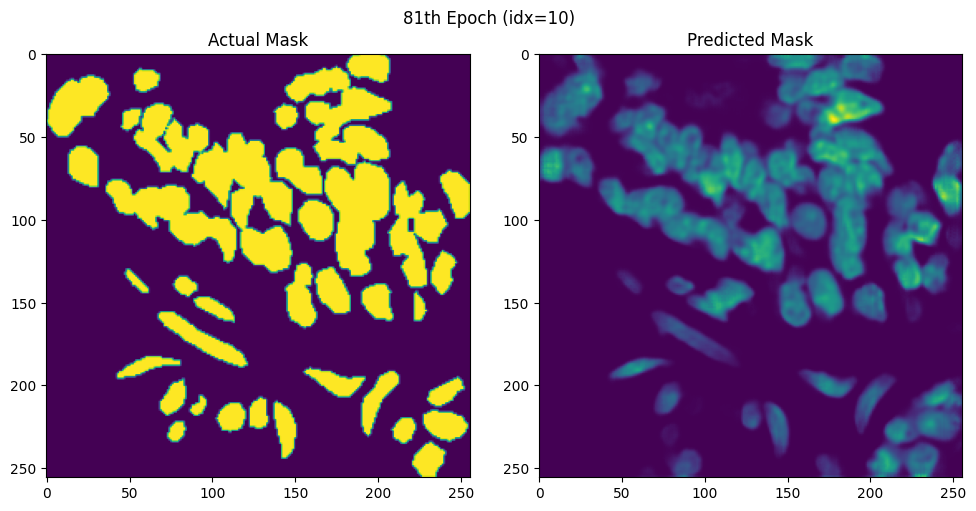

10/10 [==============================] - 2s 247ms/step - loss: 249.9976 - mse: 0.0942 - val_loss: 292.4067 - val_mse: 0.1395
Epoch 82/100
10/10 [==============================] - ETA: 0s - loss: 250.2538 - mse: 0.0864
Epoch 82: val_loss did not improve from 290.46616
10/10 [==============================] - 1s 149ms/step - loss: 250.2538 - mse: 0.0864 - val_loss: 299.9429 - val_mse: 0.1612
Epoch 83/100
10/10 [==============================] - ETA: 0s - loss: 249.9041 - mse: 0.1009
Epoch 83: val_loss improved from 290.46616 to 290.17020, saving model to checkpoint.h5
10/10 [==============================] - 2s 184ms/step - loss: 249.9041 - mse: 0.1009 - val_loss: 290.1702 - val_mse: 0.1500
Epoch 84/100
10/10 [==============================] - ETA: 0s - loss: 249.2798 - mse: 0.0886
Epoch 84: val_loss improved from 290.17020 to 288.46432, saving model to checkpoint.h5
10/10 [==============================] - 2s 185ms/step - loss: 249.2798 - mse: 0.0886 - val_loss: 288.4643 - val_mse: 0.12

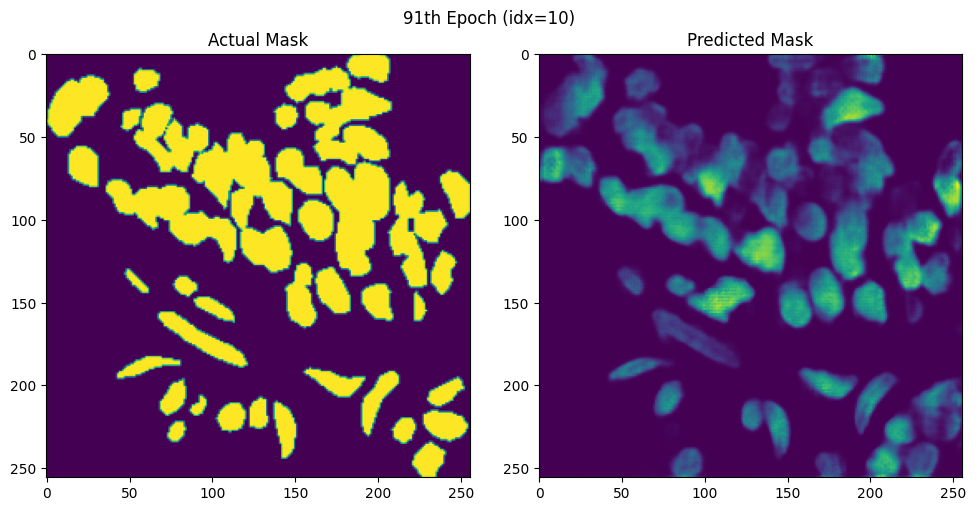

10/10 [==============================] - 2s 211ms/step - loss: 247.3860 - mse: 0.0811 - val_loss: 298.2195 - val_mse: 0.1349
Epoch 92/100
10/10 [==============================] - ETA: 0s - loss: 246.8521 - mse: 0.0753
Epoch 92: val_loss improved from 286.72122 to 286.26559, saving model to checkpoint.h5
10/10 [==============================] - 2s 177ms/step - loss: 246.8521 - mse: 0.0753 - val_loss: 286.2656 - val_mse: 0.1114
Epoch 93/100
10/10 [==============================] - ETA: 0s - loss: 247.1387 - mse: 0.0808
Epoch 93: val_loss did not improve from 286.26559
10/10 [==============================] - 1s 147ms/step - loss: 247.1387 - mse: 0.0808 - val_loss: 288.9269 - val_mse: 0.1292
Epoch 94/100
10/10 [==============================] - ETA: 0s - loss: 246.4660 - mse: 0.0811
Epoch 94: val_loss improved from 286.26559 to 285.94617, saving model to checkpoint.h5
10/10 [==============================] - ETA: 0s - loss: 246.2189 - mse: 0.0744
Epoch 95: val_loss did not improve from 28

In [24]:
history = model.fit(
    train_X, train_M,
    validation_split=VALIDATION_SIZE,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpointer, maskpredicter]
).history

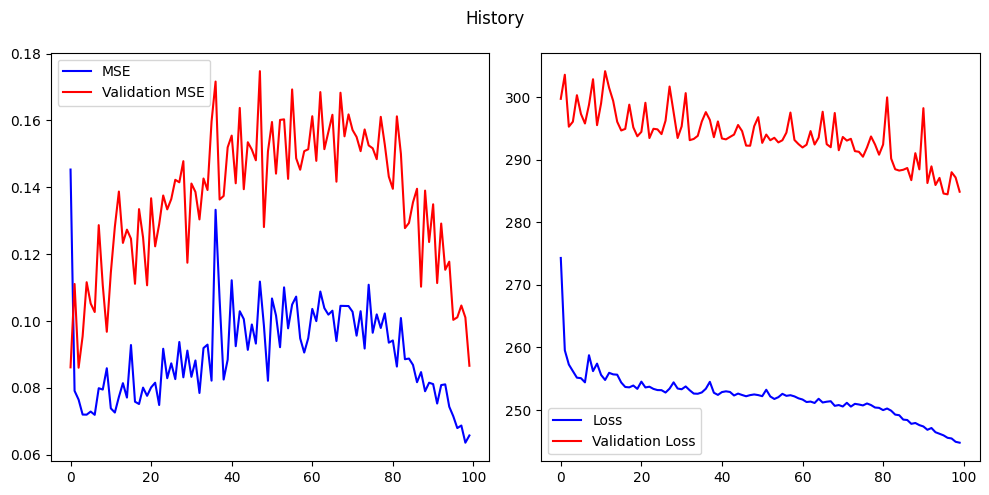

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.plot(history['mse'], c='blue', label='MSE')
ax1.plot(history['val_mse'], c='red', label='Validation MSE')
ax1.legend()

ax2.plot(history['loss'], c='blue', label='Loss')
ax2.plot(history['val_loss'], c='red', label='Validation Loss')
ax2.legend()

fig.suptitle('History')
fig.tight_layout()
plt.show()

1/1 [==============================] - 0s 20ms/step


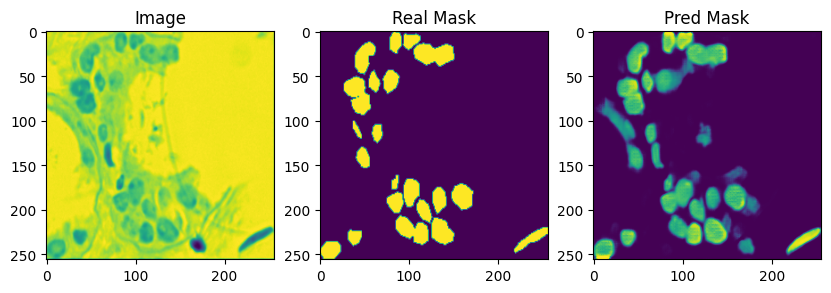

1/1 [==============================] - 0s 20ms/step


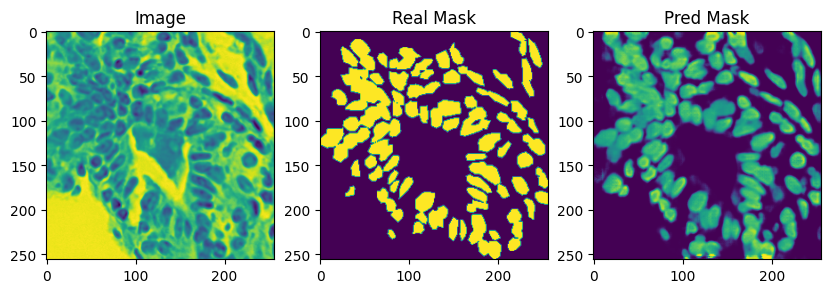

In [26]:
for image, mask in zip(test_X, test_M):
    predicted_mask = np.squeeze(model.predict(np.expand_dims(image, axis=0))[0])

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))
    ax1.imshow(image[:, :, 2])
    ax1.set_title('Image')
    ax2.imshow(mask)
    ax2.set_title('Real Mask')
    ax3.imshow(predicted_mask)
    ax3.set_title('Pred Mask')
    plt.show()